# **Import Libraries**

In [1]:
!pip install transformers
!pip install sentencepiece


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 48.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 91.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 66.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.0 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

import re, string
import nltk

from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

from transformers import TFMT5EncoderModel, AutoTokenizer



import tensorflow as tf
from tensorflow import keras


from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix


seed=42
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

<ipython-input-2-b93f3f7342db>:33: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


<Figure size 640x480 with 0 Axes>

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.max_rows', None)  # Display all rows
pd.set_option('display.expand_frame_repr', False)  # Display DataFrame in a single frame

# EDA

In [5]:
class Datapreprocessing:

    def __init__(self,file_path,max_length):
        self.max_length = max_length
        self.file_path = file_path



    def dataframe(self):
        with open(self.file_path) as f:
            text_li = f.readlines()
        en_text = []
        zh_text = []
        en_sentence_center = []
        zh_sentence_center = []
        en_align_text = []
        zh_align_text = []
        label_text = []
        en_align_index = []
        zh_align_index = []
        pair_list1 = []
        pair_list2 = []

        for i, line in enumerate(text_li):
            if i%4== 0:
                en_text.append(line.strip())
            elif i%4 ==1:
                zh_text.append(line.strip())
            elif i%4==2:
                en_align = line.strip().split(':')[0]
                zh_align = line.strip().split(':')[-1]
                en_align_text.append(en_align)
                zh_align_text.append(zh_align)
            elif i%4==3:
                lanel_line = line
                label_text.append(lanel_line.strip())
        for en, zh, en_sent,zh_sent in zip(en_align_text, zh_align_text, en_text, zh_text):
            pair1 = en + '[SEP]' + zh + '[SEP]' + en_sent+ '[SEP]' + zh_sent
            pair_list1.append(pair1)
        for en, en_sent in zip(en_align_text, en_text):
            pair2 = en + '[SEP]' + en_sent
            pair_list2.append(pair2)








        data = {
        'en_sent': en_text,
        'zh_sent': zh_text,
        'en_align': en_align_text,
        'zh_align': zh_align_text,
        'pair1':pair_list1,
        'pair2':pair_list2,
        'label': label_text}

        df = pd.DataFrame(data)

        return df



    def test1_df(self):
        with open(self.file_path,encoding='latin-1') as q:
            text_li = q.readlines()
        text_list = []
        label_list = []

        for all in text_li:
            text = all.split('@')[0]
            label = all.split('@')[1].strip()
            text_list.append(text)
            label_list.append(label)
        data = {
            'sent': text_list,
            'label':label_list
        }
        df = pd.DataFrame(data)
        return df



file_path_train = '/content/gdrive/MyDrive/Colab Notebooks/literal translationese/codes_files/6_post-editing/data_3_PE_pattern2/good_bad_with_labels_train.txt'
file_path_test = '/content/gdrive/MyDrive/Colab Notebooks/literal translationese/codes_files/6_post-editing/data_3_PE_pattern2/good_bad_with_labels_test.txt'

max_len = 512
df = Datapreprocessing(file_path_train, max_len)
df_train = df.dataframe()
print(df_train.head(5))

df_test = Datapreprocessing(file_path_test, max_len)
df_test = df_test.dataframe()
print(df_test.head(5))

                                             en_sent                                            zh_sent en_align zh_align                                              pair1                                              pair2              label
0  We walked in so pure and bright a light, gildi...  我们漫步于其中的光照，是这样的纯美与熠耀，满目衰草树叶，一片金黄，晃晃之中又是这般柔和和恬静...     pure       恬静  pure[SEP]恬静[SEP]We walked in so pure and brigh...  pure[SEP]We walked in so pure and bright a lig...               good
1  But a good reason why computer languages are m...          计算机语言之所以如此的专横，其中的一个好的理由就是让程序变得更精确的而且没有歧义。  precise      精确的  precise[SEP]精确的[SEP]But a good reason why comp...  precise[SEP]But a good reason why computer lan...  bad:transposition
2  Individuals must provide fifty thousand dollar...                         个人必须给交易公司交5.5万美元或更多钱来购买股票。  provide        给  provide[SEP]给[SEP]Individuals must provide fif...  provide[SEP]Individuals must provide fifty tho...               good
3  You are not very lonely? 

In [ ]:
df_train.head()


,en_sent,zh_sent,en_align,zh_align,pair1,pair2,label
0,"We walked in so pure and bright a light, gildi...",我们漫步于其中的光照，是这样的纯美与熠耀，满目衰草树叶，一片金黄，晃晃之中又是这般柔和和恬静...,pure,恬静,pure[SEP]恬静[SEP]We walked in so pure and brigh...,pure[SEP]We walked in so pure and bright a lig...,good
1,But a good reason why computer languages are m...,计算机语言之所以如此的专横，其中的一个好的理由就是让程序变得更精确的而且没有歧义。,precise,精确的,precise[SEP]精确的[SEP]But a good reason why comp...,precise[SEP]But a good reason why computer lan...,bad:transposition
2,Individuals must provide fifty thousand dollar...,个人必须给交易公司交5.5万美元或更多钱来购买股票。,provide,给,provide[SEP]给[SEP]Individuals must provide fif...,provide[SEP]Individuals must provide fifty tho...,good
3,You are not very lonely? It lavished on the mo...,你不是很孤独的吗？那就把山杜鹃撒向天空，把它融入燃烧的青春世界吧！,lonely,孤独的,lonely[SEP]孤独的[SEP]You are not very lonely? It...,lonely[SEP]You are not very lonely? It lavishe...,bad:transposition
4,"An incidental allusion, purposely thrown out, ...",采取偶然的方式故意提起的日期问题（今天是星期几？ 是本月几号？） 引起了医生的考虑和计算，他...,him,,"him[SEP][SEP]An incidental allusion, purposely...","him[SEP]An incidental allusion, purposely thro...",good


In [ ]:
df_test.head()

,en_sent,zh_sent,en_align,zh_align,pair1,pair2,label
0,"In able- bodied people, these ""walking circuit...",对于健康的人来说，这些“行走回路”一旦收到大脑发出的信号之后，便迅速行动。但如果脊髓受到破坏...,receive,回路,"receive[SEP]回路[SEP]In able- bodied people, the...","receive[SEP]In able- bodied people, these ""wal...",good
1,Learn the lead steps for disco choreography wi...,学习迪斯科舞蹈与有用的提示步骤率先在这个自由的影片有经验的舞蹈老师在舞厅跳舞。,in,在,in[SEP]在[SEP]Learn the lead steps for disco ch...,in[SEP]Learn the lead steps for disco choreogr...,good
2,You might like to place a candle on your altar...,你可以在祭坛上插一支蜡烛或放些其他对你有意义的物件。,have,有,have[SEP]有[SEP]You might like to place a candl...,have[SEP]You might like to place a candle on y...,good
3,Now that we ’ve discussed the key elements to ...,既然我们已经讨论了使用本地邮件副本的环境的关键因素，那么下面看一下如何被创建并配置环境。,is created,被创建,is created[SEP]被创建[SEP]Now that we ’ve discuss...,is created[SEP]Now that we ’ve discussed the k...,bad:lexical_shift
4,"You've captured it for a moment, and finding t...",你在一瞬间捕捉了它，发现这张静态的照片让你感觉,finding,发现,finding[SEP]发现[SEP]You've captured it for a mo...,"finding[SEP]You've captured it for a moment, a...",good


In [ ]:
print('Train shape:',df_train.shape)
print('Test shape:',df_test.shape)

Train shape: (82176, 7)
Test shape: (9131, 7)


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82176 entries, 0 to 82175
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   en_sent   82176 non-null  object
 1   zh_sent   82176 non-null  object
 2   en_align  82176 non-null  object
 3   zh_align  82176 non-null  object
 4   pair1     82176 non-null  object
 5   pair2     82176 non-null  object
 6   label     82176 non-null  object
dtypes: object(7)
memory usage: 4.4+ MB


In [6]:
label_counts = df_train.label.value_counts()
total_samples = len(df_train)
label_percentages = label_counts #/ total_samples
print(label_percentages)

good                            51923
bad:transposition                7067
bad:generalization               5165
bad:unaligned_reduction          4071
bad:unaligned_explicitation      4036
bad:particularization            2929
bad:equivalence                  2506
bad:modulation                   1928
bad:lexical_shift                1349
bad:modulation_transposition     1202
Name: label, dtype: int64


In [7]:
label_counts = df_test.label.value_counts()
total_samples = len(df_test)
label_percentages = label_counts #/ total_samples
print(label_percentages)

good                            5770
bad:transposition                785
bad:generalization               574
bad:unaligned_reduction          452
bad:unaligned_explicitation      449
bad:particularization            325
bad:equivalence                  278
bad:modulation                   214
bad:lexical_shift                150
bad:modulation_transposition     134
Name: label, dtype: int64


In [ ]:
def sentiment_categories(category):
    if category=='good':
        return 0
    elif category=='bad:transposition':
        return 1
    elif category=='bad:unaligned_explicitation':
        return 2
    elif category=='bad:unaligned_reduction':
        return 3
    elif category=='bad:lexical_shift':
        return 4
    elif category=='bad:equivalence':
        return 5
    elif category=='bad:generalization':
        return 6
    elif category=='bad:modulation':
        return 7
    elif category=='bad:particularization':
        return 8
    elif category=='bad:modulation_transposition':
        return 9


In [ ]:
df_train['label']=df_train['label'].apply(sentiment_categories)


In [ ]:
df_train.head()

,en_sent,zh_sent,en_align,zh_align,pair1,pair2,label
0,"We walked in so pure and bright a light, gildi...",我们漫步于其中的光照，是这样的纯美与熠耀，满目衰草树叶，一片金黄，晃晃之中又是这般柔和和恬静...,pure,恬静,pure[SEP]恬静[SEP]We walked in so pure and brigh...,pure[SEP]We walked in so pure and bright a lig...,0
1,But a good reason why computer languages are m...,计算机语言之所以如此的专横，其中的一个好的理由就是让程序变得更精确的而且没有歧义。,precise,精确的,precise[SEP]精确的[SEP]But a good reason why comp...,precise[SEP]But a good reason why computer lan...,1
2,Individuals must provide fifty thousand dollar...,个人必须给交易公司交5.5万美元或更多钱来购买股票。,provide,给,provide[SEP]给[SEP]Individuals must provide fif...,provide[SEP]Individuals must provide fifty tho...,0
3,You are not very lonely? It lavished on the mo...,你不是很孤独的吗？那就把山杜鹃撒向天空，把它融入燃烧的青春世界吧！,lonely,孤独的,lonely[SEP]孤独的[SEP]You are not very lonely? It...,lonely[SEP]You are not very lonely? It lavishe...,1
4,"An incidental allusion, purposely thrown out, ...",采取偶然的方式故意提起的日期问题（今天是星期几？ 是本月几号？） 引起了医生的考虑和计算，他...,him,,"him[SEP][SEP]An incidental allusion, purposely...","him[SEP]An incidental allusion, purposely thro...",0


In [ ]:
df_test['label']=df_test['label'].apply(sentiment_categories)

In [ ]:
df_test.head()

,en_sent,zh_sent,en_align,zh_align,pair1,pair2,label
0,"In able- bodied people, these ""walking circuit...",对于健康的人来说，这些“行走回路”一旦收到大脑发出的信号之后，便迅速行动。但如果脊髓受到破坏...,receive,回路,"receive[SEP]回路[SEP]In able- bodied people, the...","receive[SEP]In able- bodied people, these ""wal...",0
1,Learn the lead steps for disco choreography wi...,学习迪斯科舞蹈与有用的提示步骤率先在这个自由的影片有经验的舞蹈老师在舞厅跳舞。,in,在,in[SEP]在[SEP]Learn the lead steps for disco ch...,in[SEP]Learn the lead steps for disco choreogr...,0
2,You might like to place a candle on your altar...,你可以在祭坛上插一支蜡烛或放些其他对你有意义的物件。,have,有,have[SEP]有[SEP]You might like to place a candl...,have[SEP]You might like to place a candle on y...,0
3,Now that we ’ve discussed the key elements to ...,既然我们已经讨论了使用本地邮件副本的环境的关键因素，那么下面看一下如何被创建并配置环境。,is created,被创建,is created[SEP]被创建[SEP]Now that we ’ve discuss...,is created[SEP]Now that we ’ve discussed the k...,4
4,"You've captured it for a moment, and finding t...",你在一瞬间捕捉了它，发现这张静态的照片让你感觉,finding,发现,finding[SEP]发现[SEP]You've captured it for a mo...,"finding[SEP]You've captured it for a moment, a...",0


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("google/mt5-large")

You are using the legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This means that tokens that come after special tokens will not be properly handled. We recommend you to read the related pull request available at https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:470: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [ ]:
tweet_len=[]
for text in df_test.pair1:
    tokens=tokenizer.encode(text,max_length=512)
    tweet_len.append(len(tokens))
print(max(tweet_len))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


463


<ipython-input-21-aa8050e070b6>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(tweet_len)


Text(0.5, 0, 'Number of words')

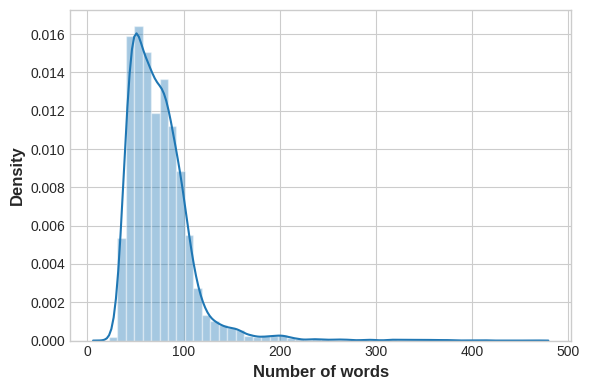

In [ ]:
f,ax=plt.subplots(figsize=(6,4))
sns.distplot(tweet_len)
plt.xlabel('Number of words')

In [ ]:
df_train=df_train[['pair1','pair2','label']]


In [ ]:
df_train.head()

,pair1,pair2,label
0,pure[SEP]恬静[SEP]We walked in so pure and brigh...,pure[SEP]We walked in so pure and bright a lig...,0
1,precise[SEP]精确的[SEP]But a good reason why comp...,precise[SEP]But a good reason why computer lan...,1
2,provide[SEP]给[SEP]Individuals must provide fif...,provide[SEP]Individuals must provide fifty tho...,0
3,lonely[SEP]孤独的[SEP]You are not very lonely? It...,lonely[SEP]You are not very lonely? It lavishe...,1
4,"him[SEP][SEP]An incidental allusion, purposely...","him[SEP]An incidental allusion, purposely thro...",0


In [ ]:
df_test=df_test[['pair1','pair2','label']]

In [ ]:
df_test.head()

,pair1,pair2,label
0,"receive[SEP]回路[SEP]In able- bodied people, the...","receive[SEP]In able- bodied people, these ""wal...",0
1,in[SEP]在[SEP]Learn the lead steps for disco ch...,in[SEP]Learn the lead steps for disco choreogr...,0
2,have[SEP]有[SEP]You might like to place a candl...,have[SEP]You might like to place a candle on y...,0
3,is created[SEP]被创建[SEP]Now that we ’ve discuss...,is created[SEP]Now that we ’ve discussed the k...,4
4,finding[SEP]发现[SEP]You've captured it for a mo...,"finding[SEP]You've captured it for a moment, a...",0


# Cleaning the Tweets

In [ ]:
#shuffle train data and reset index
df_train=df_train.sample(frac=1).reset_index(drop=True)
df_train.head()

,pair1,pair2,label
0,"I[SEP]我[SEP]For next month's column, I'm going...","I[SEP]For next month's column, I'm going back ...",0
1,"[SEP][SEP]He was a restless fellow, and did no...","[SEP]He was a restless fellow, and did not alw...",2
2,[SEP][SEP]A ship stabilizing fin controller ba...,[SEP]A ship stabilizing fin controller based o...,2
3,is reprinted[SEP]被转载[SEP]This message by the w...,is reprinted[SEP]This message by the whole nat...,0
4,in[SEP][SEP]Implements an effective staff rela...,in[SEP]Implements an effective staff relations...,0


In [ ]:
df_test=df_test.sample(frac=1).reset_index(drop=True)
df_test.head()

,pair1,pair2,label
0,"live[SEP]活[SEP]For example, if one of your nei...","live[SEP]For example, if one of your neighbor ...",6
1,"only[SEP]只[SEP]Says: ""I only want you for sex,...","only[SEP]Says: ""I only want you for sex, so ca...",0
2,in[SEP]在[SEP]The scene is a circus-crowded wit...,in[SEP]The scene is a circus-crowded with spec...,0
3,"plural[SEP]形式[SEP]The verb is plural, but the ...","plural[SEP]The verb is plural, but the reason ...",0
4,it[SEP][SEP]Open - angle glaucoma often has no...,it[SEP]Open - angle glaucoma often has no sign...,0


In [ ]:
df_train.label.value_counts()

0    51923
1     7067
6     5165
3     4071
2     4036
8     2929
5     2506
7     1928
4     1349
9     1202
Name: label, dtype: int64

# Splitting the data into train/valid/test

In [ ]:
X1=df_train['pair1'].values
# X2=df_train['pair2'].values
y=df_train['label'].values

In [ ]:
# X1_train,X1_val,X2_train,X2_val,y_train,y_val=train_test_split(X1,X2,y,test_size=0.1,stratify=y,random_state=42)
X1_train,X1_val,y_train,y_val=train_test_split(X1,y,test_size=0.1,stratify=y,random_state=42)

In [ ]:
X1_test=df_test['pair1'].values
y_test=df_test['label'].values

In [ ]:
y_train_label=y_train.copy()
y_val_label=y_val.copy()
y_test_label=y_test.copy()

In [ ]:
hotencoder=preprocessing.OneHotEncoder()
y_train=hotencoder.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_val=hotencoder.fit_transform(np.array(y_val).reshape(-1, 1)).toarray()
y_test=hotencoder.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

# Model2: BERT Model

In [ ]:
MAX_LEN=512

In [ ]:
def tokenize(tweets,max_len=MAX_LEN):
    input_ids=[]
    attention_masks=[]
    for i in range(len(tweets)):
        encoding=tokenizer.encode_plus(tweets[i],truncation=True,add_special_tokens=True,max_length=MAX_LEN,
                                       padding='max_length',return_attention_mask=True)
        if len(encoding['input_ids']) != 512:
            print(len(encoding['input_ids']))
        input_ids.append(encoding['input_ids'])
        attention_masks.append(encoding['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)


In [ ]:
train1_input_ids,train1_attention_masks=tokenize(X1_train,MAX_LEN)
test1_input_ids,test1_attention_masks=tokenize(X1_test,MAX_LEN)
val1_input_ids,val1_attention_masks=tokenize(X1_val,MAX_LEN)

# train2_input_ids,train2_attention_masks=tokenize(X2_train,MAX_LEN)
# test2_input_ids,test2_attention_masks=tokenize(X2_test,MAX_LEN)
# val2_input_ids,val2_attention_masks=tokenize(X2_val,MAX_LEN)

In [ ]:
t5_model=TFMT5EncoderModel.from_pretrained("google/mt5-large")

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
Some layers from the model checkpoint at google/mt5-large were not used when initializing TFMT5EncoderModel: ['decoder', 'lm_head']
- This IS expected if you are initializing TFMT5EncoderModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFMT5EncoderModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the l

In [ ]:
def create_model(bert_model,max_len=MAX_LEN):

    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-05)
    loss_fn=tf.keras.losses.CategoricalCrossentropy(from_logits=False)
    accuracy=tf.keras.metrics.CategoricalAccuracy()

    input_ids=tf.keras.Input(shape=(max_len,),dtype='int32')
    embeddings=bert_model(input_ids)[0]
    flattened_embeddings = tf.keras.layers.Flatten()(embeddings)
    output=tf.keras.layers.Dense(10,activation='softmax')(flattened_embeddings)
    model=tf.keras.models.Model(inputs=[input_ids],outputs=output)
    model.compile(optimizer,loss=loss_fn,metrics=accuracy)

    return model


In [ ]:
model=create_model(t5_model,MAX_LEN)
model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512)]             0         
                                                                 
 tfmt5_encoder_model (TFMT5E  TFBaseModelOutput(last_h  564446720
 ncoderModel)                idden_state=(None, 512,             
                             1024),                              
                              hidden_states=None, att            
                             entions=None)                       
                                                                 
 flatten (Flatten)           (None, 524288)            0         
                                                                 
 dense (Dense)               (None, 10)                5242890   
                                                                 
Total params: 569,689,610
Trainable params: 569,689,610
Non-t

In [ ]:
config = t5_model.config

# Check the number of encoder layers
num_encoder_layers = config.num_layers
print("Number of Encoder Layers:", num_encoder_layers)

Number of Encoder Layers: 24


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import Callback
# tf.config.run_functions_eagerly(True)
# custom_objects = {'TFMT5EncoderModel': TFMT5EncoderModel}

# # Load the existing model with custom objects
# with tf.keras.utils.custom_object_scope(custom_objects):
#     model = load_model('/content/gdrive/MyDrive/Colab Notebooks/literal translationese/codes_files/6_post-editing/save_checkpoints/TFt5_model.h5')



initial_l2_regularization = 0.01

def dynamic_l2_regularization(epoch):
    if epoch < 2:
        return 0
    elif epoch >= 2 and epoch <= 3 :
        return initial_l2_regularization
    elif epoch > 3:
        return initial_l2_regularization * 0.1  # Update the regularization strength after epoch 10



# Custom callback to update L2 regularization strength during training
class L2RegularizationUpdater(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        l2_regularization = dynamic_l2_regularization(epoch)
        for layer in self.model.layers:
            if isinstance(layer, tf.keras.layers.Dense):
                layer.kernel_regularizer = regularizers.l2(l2_regularization)
        print(f"L2 regularization strength: {l2_regularization}")



checkpoint_filepath = '/content/gdrive/MyDrive/Colab Notebooks/literal translationese/codes_files/6_post-editing/save_checkpoints_pattern2/TFmt5_best_checkpoint.h5'

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    checkpoint_filepath,
    monitor='val_accuracy',  # Metric to monitor (e.g., validation accuracy)
    save_best_only=True,     # Save only the best checkpoint
    mode='max'               # Mode for comparison (e.g., maximize the metric)
)

def learning_rate_scheduler(epoch, learning_rate):
    if epoch < 3:
        return learning_rate  # Keep the initial learning rate for the first 10 epochs
    else:
        return learning_rate * tf.math.exp(-0.1)  # Decrease the learning rate exponentially

l2_callback = L2RegularizationUpdater()

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(learning_rate_scheduler)


early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    train1_input_ids,
    y_train,
    validation_data=([val1_input_ids], y_val),
    epochs=50,
    batch_size=4,
    callbacks=[early_stop, checkpoint, lr_scheduler, l2_callback]  # Pass the early_stop callback
)



L2 regularization strength: 0
Epoch 1/50
   13/18490 [..............................] - ETA: 7:43:30 - loss: 1.4100 - categorical_accuracy: 0.5962

KeyboardInterrupt: ignored

In [ ]:
model.save('/content/gdrive/MyDrive/Colab Notebooks/literal translationese/codes_files/6_post-editing/save_checkpoints/TFt5_model.h5')

In [ ]:
res=model.predict([test1_input_ids])

286/286 [==============================] - 104s 343ms/step


In [ ]:
output_task1 = res  # Predictions for task 1
# output_task2 = res[1]  # Predictions for task 2

y_pred_task1 = np.zeros_like(output_task1)
y_pred_task1[np.arange(len(y_pred_task1)), output_task1.argmax(1)] = 1

# y_pred_task2 = np.zeros_like(output_task2)
# y_pred_task2[np.arange(len(y_pred_task2)), output_task2.argmax(1)] = 1

In [ ]:
confusion_matrix(y_test.argmax(1),y_pred_task1.argmax(1))

array([[3043,   58,   44],
       [ 239, 3022,  100],
       [ 173,  158, 2294]])

In [ ]:
class_labels=['literal','bad','non-literal']

In [ ]:
# mbert  en+zh+en_sent+zh_sent
print(classification_report(y_test.argmax(1),y_pred_task1.argmax(1),target_names=class_labels))

              precision    recall  f1-score   support

     literal       0.88      0.97      0.92      3145
         bad       0.93      0.90      0.92      3361
 non-literal       0.94      0.87      0.91      2625

    accuracy                           0.92      9131
   macro avg       0.92      0.91      0.91      9131
weighted avg       0.92      0.92      0.92      9131



<Axes: >

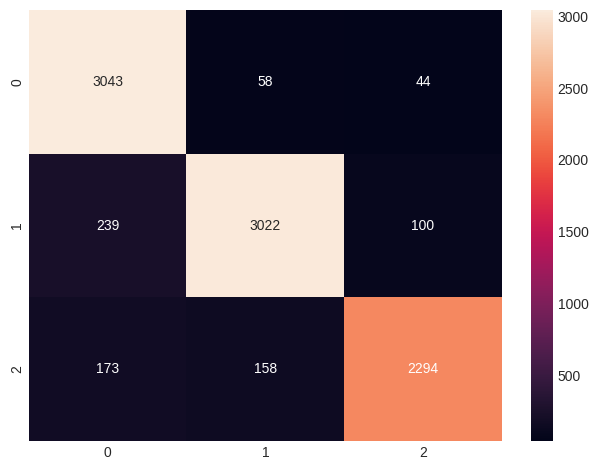

In [ ]:
sns.heatmap(confusion_matrix(y_test.argmax(1),y_pred_task1.argmax(1)),annot=True,fmt="d")